# Data overview and processing

In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sbn


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
ar = "application_record.csv"
cr = "credit_record.csv"
credit = pd.read_csv(cr)
application= pd.read_csv(ar)

In [2]:
len_app = len(set(application['ID'])) # how many unique ID in application record?
len_cred = len(set(credit['ID'])) # how many unique ID in credit record?
common_id = len(set(application['ID']).intersection(set(credit['ID']))) # how many IDs do two tables share?

print("unique ID in application record: ", len_app)
print("unique ID in credit record: ",len_cred)
print("IDs do two tables share: ",common_id)

unique ID in application record:  438510
unique ID in credit record:  45985
IDs do two tables share:  36457


In [3]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


### Credit table

In [4]:
# Customer with due or not 
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit.sort_values(by = ['ID'], inplace = True)
credit = credit.groupby('ID')['status'].max().reset_index() 
#If there is any 'due' status (1) present, the 'status' value will be 1 ('due'), otherwise, it will be 0 ('non-due').

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      45985 non-null  int64
 1   status  45985 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 404.3 KB


### Application table

In [6]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
application.drop(['OCCUPATION_TYPE','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'], axis=1, inplace=True) 

In [8]:
objects_data = pd.DataFrame(application.dtypes =='object').reset_index()
object_type = objects_data[objects_data[0] == True]['index']
object_type

1            CODE_GENDER
2           FLAG_OWN_CAR
3        FLAG_OWN_REALTY
6       NAME_INCOME_TYPE
7    NAME_EDUCATION_TYPE
8     NAME_FAMILY_STATUS
9      NAME_HOUSING_TYPE
Name: index, dtype: object

In [9]:
# all non-numeric data to numeric data using LabelEncoder().
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for x in application:
    if application[x].dtypes == 'object':
        application[x] = le.fit_transform(application[x])

In [10]:
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1.0


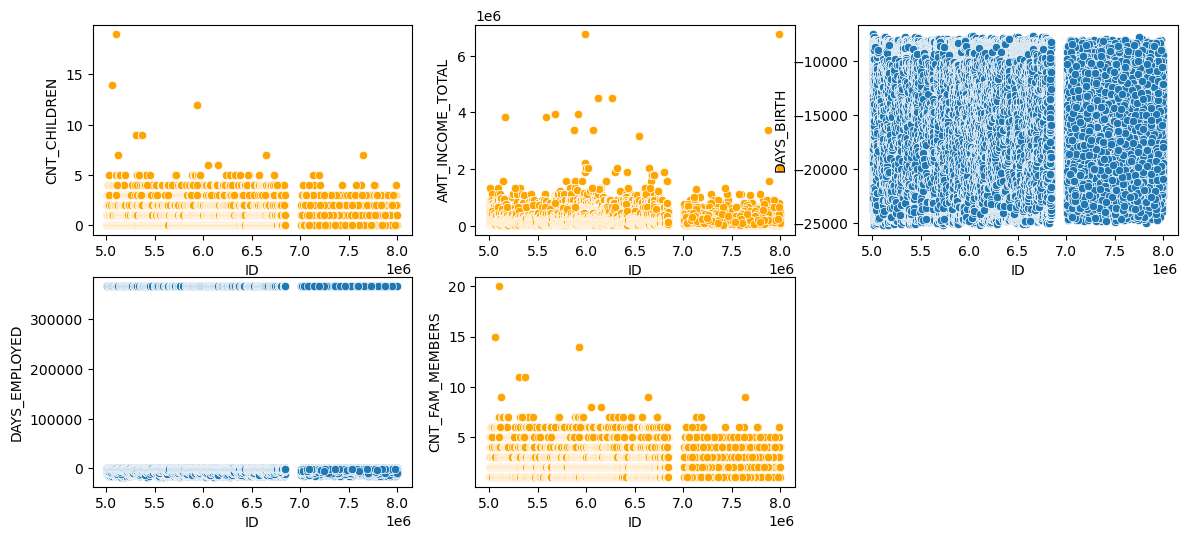

In [11]:
# exclude outliers from the data sample.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

sbn.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0], color='orange')
sbn.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1], color='orange')
sbn.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sbn.scatterplot(x='ID', y='DAYS_EMPLOYED', data=application, ax=ax[1][0])
sbn.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[1][1], color='orange')
fig.delaxes(ax[1][2])


In [12]:
# for CNT_CHILDREN
q_hi = application['CNT_CHILDREN'].quantile(0.999)
q_low = application['CNT_CHILDREN'].quantile(0.001)
application = application[(application['CNT_CHILDREN'] > q_low) & (application['CNT_CHILDREN'] < q_hi)]

# for AMT_INCOME_TOTAL
q_hi = application['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = application['AMT_INCOME_TOTAL'].quantile(0.001)
application = application[(application['AMT_INCOME_TOTAL'] > q_low) & (application['AMT_INCOME_TOTAL'] < q_hi)]

# for CNT_FAM_MEMBERS
q_hi = application['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = application['CNT_FAM_MEMBERS'].quantile(0.001)
application = application[(application['CNT_FAM_MEMBERS'] > q_low) & (application['CNT_FAM_MEMBERS'] < q_hi)]


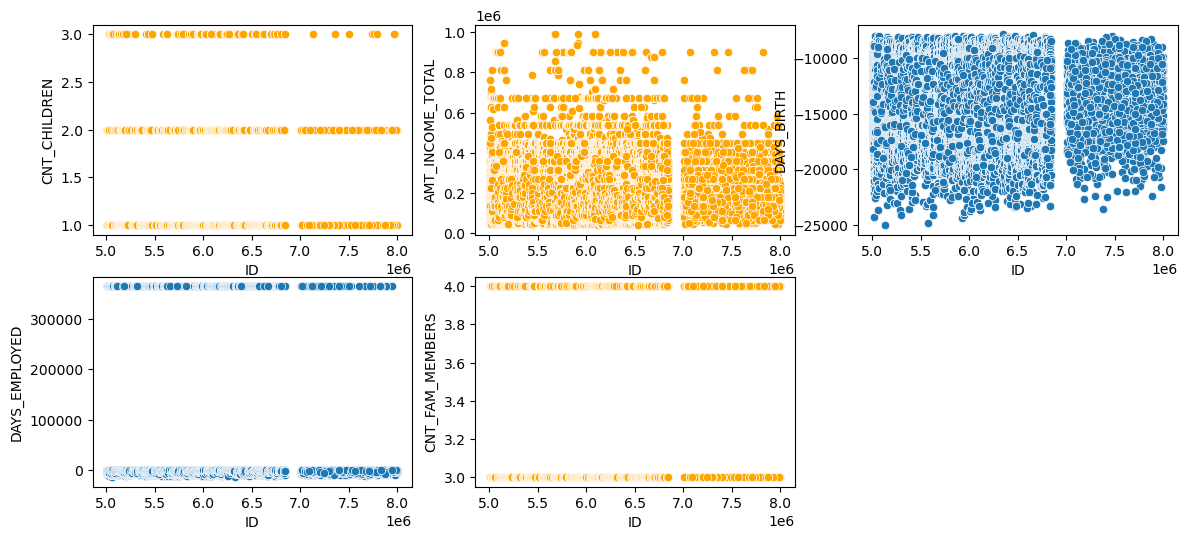

In [13]:
# exclude outliers from the data sample.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

sbn.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0], color='orange')
sbn.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1], color='orange')
sbn.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sbn.scatterplot(x='ID', y='DAYS_EMPLOYED', data=application, ax=ax[1][0])
sbn.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[1][1], color='orange')
fig.delaxes(ax[1][2])


### Final table

In [14]:
ua_id = application['ID'].unique()
uc_id = credit['ID'].unique()

ua_id_set = set(ua_id)
uc_id_set = set(uc_id)

# Find the common IDs using the intersection method of sets
ids = list(ua_id_set.intersection(uc_id_set))

In [15]:
credit = credit[credit['ID'].isin(ids)]
application = application[application['ID'].isin(ids)]

In [16]:
# Create a new DataFrame with unique 'ID' values and 'status' column showing 'due' if any 'due' status is present
credit = credit.groupby('ID')['status'].max().reset_index()

In [17]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      9516 non-null   int64
 1   status  9516 non-null   int8 
dtypes: int64(1), int8(1)
memory usage: 83.8 KB


In [19]:
data = pd.merge(application, credit, on='ID', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9516 entries, 0 to 9515
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9516 non-null   int64  
 1   CODE_GENDER          9516 non-null   int64  
 2   FLAG_OWN_CAR         9516 non-null   int64  
 3   FLAG_OWN_REALTY      9516 non-null   int64  
 4   CNT_CHILDREN         9516 non-null   int64  
 5   AMT_INCOME_TOTAL     9516 non-null   float64
 6   NAME_INCOME_TYPE     9516 non-null   int64  
 7   NAME_EDUCATION_TYPE  9516 non-null   int64  
 8   NAME_FAMILY_STATUS   9516 non-null   int64  
 9   NAME_HOUSING_TYPE    9516 non-null   int64  
 10  DAYS_BIRTH           9516 non-null   int64  
 11  DAYS_EMPLOYED        9516 non-null   int64  
 12  CNT_FAM_MEMBERS      9516 non-null   float64
 13  status               9516 non-null   int8   
dtypes: float64(2), int64(11), int8(1)
memory usage: 1.0 MB


### Training


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

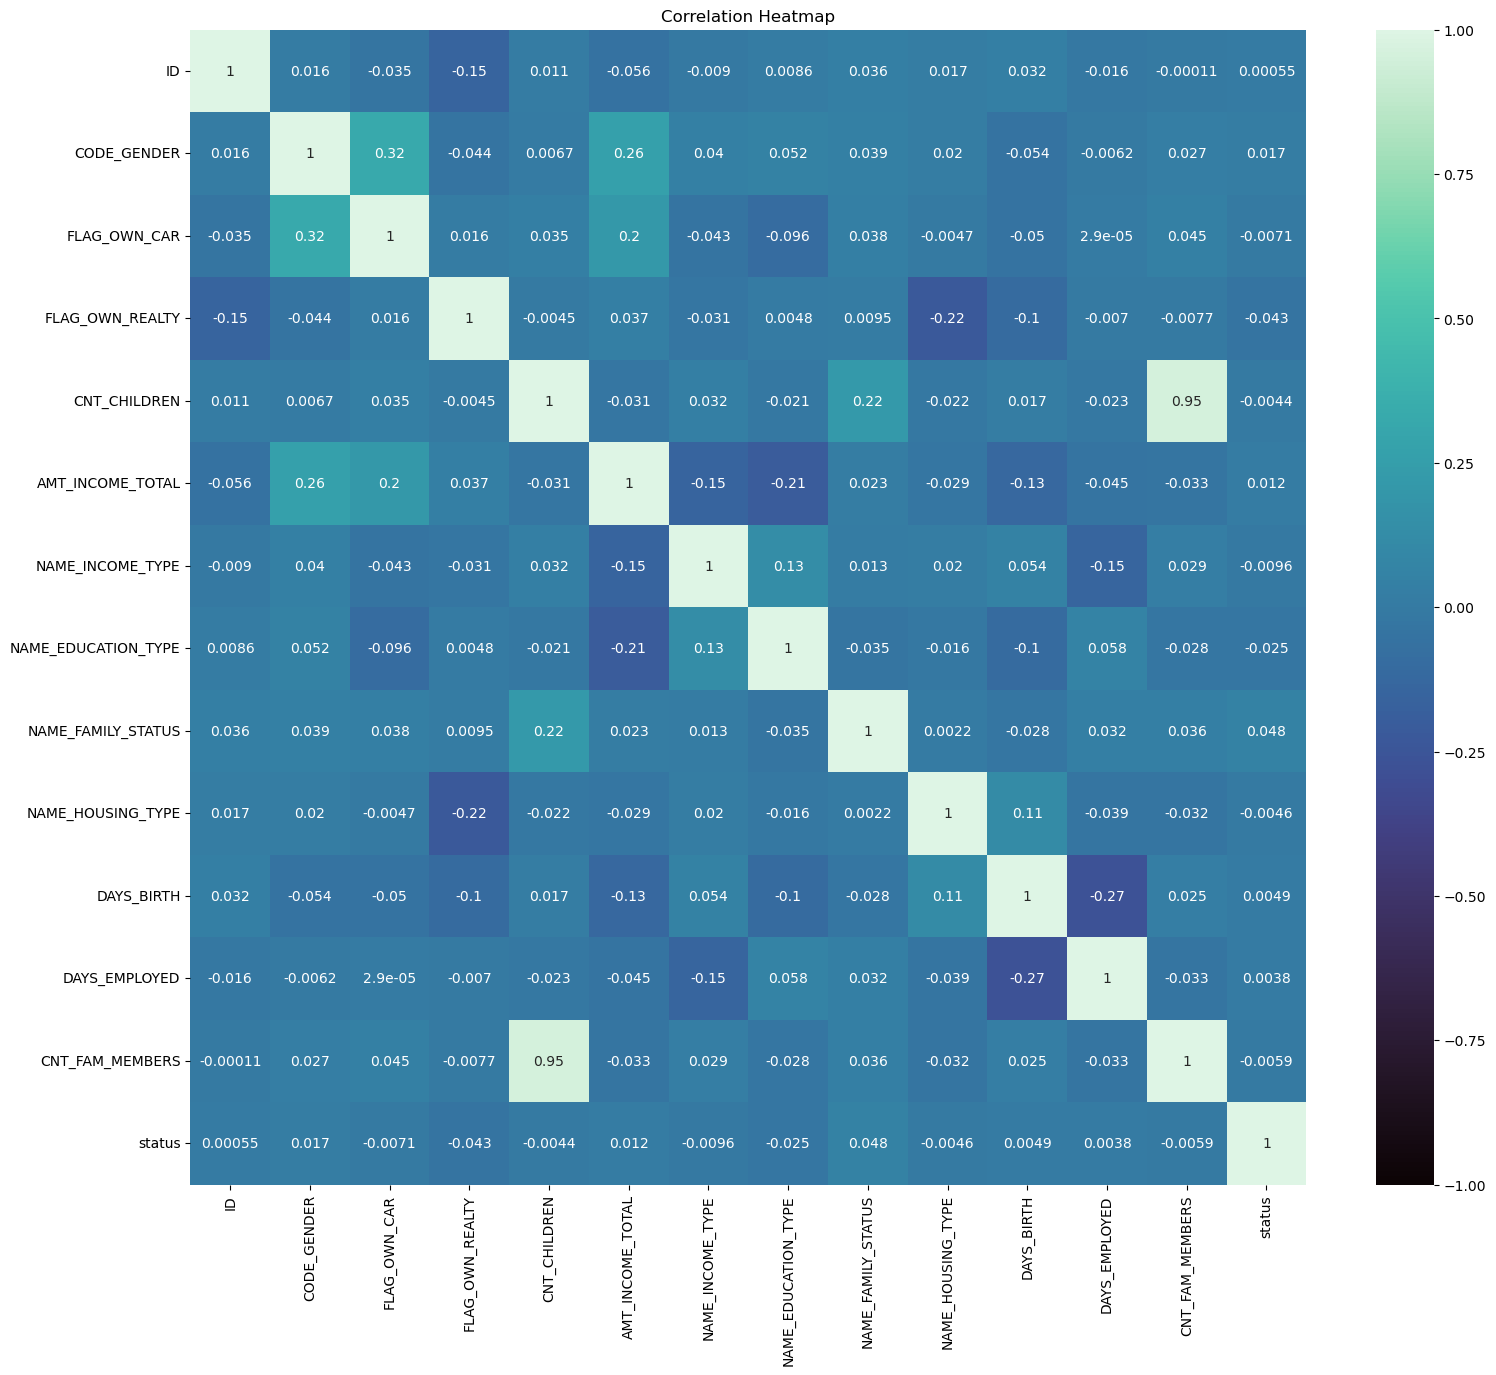

In [24]:
corr = data.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Heatmap")
plt.show()

### Data splitting

In [29]:
X = data.iloc[:,1:-1] # X value contains all the variables except labels
y = data.iloc[:,-1] # these are the labels


### Training 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [31]:
models = {
    LogisticRegression(): "   Logistic Regression",
    SVC():                "Support Vector Machine",
    MLPClassifier():      "        Neural Network"
  
}

for model in models.keys():
    model.fit(X_train, y_train)

In [32]:
for model, name in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

   Logistic Regression: 98.35%
Support Vector Machine: 98.35%
        Neural Network: 98.35%
